# Which borough has the most noise complaints (or, more selecting data)

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# !pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-3", port=8083, reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:8080
SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/efb9ad13d52c4fc6a826ecc974857ef7.sqlite



# Data owner: upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from syft import Worker, MessageStatus
from syft.service.project.project import Project
from syft.util.util import PANDAS_DATA

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [6]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [7]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

In [8]:
from syft.serde.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,555375,1981-09-03 11:05:57,2011-06-10 02:16:33,NYPD,Dawn Austin,Noise - Street/Sidewalk,Broken Fence,Public Stairs,86201,"378 David Causeway Suite 750\nFergusonmouth, H...",Mariah Hobbs,Wilson Plains,Sims Shores,Cunningham Locks,Hamilton Glens,ADDRESS,Bergerberg,BARTEL PRITCHARD SQUARE,Precinct,Unassigned,2005-12-25 01:31:02,1972-04-18 04:50:26,01 STATEN ISLAND,BRONX,701389,124379,Steven Thomas,QUEENS,Jeffrey Howard,B109,Region 8,75R721,7184301833,"232 Richardson Grove\nNew Ryan, AR 41701",LONG ISLAND CITY,NY,86201,N,NaN,Commuter Van,MANHATTAN,Port Authority Bus Terminal,Nassau Expwy,West/Staten Island Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),Flushing #1 Field,Manhattan Bound,Austen,53.813883,-75.473656,"(-77.087071, 132.148297)"
1,368232,1972-04-18 04:50:26,2018-08-27 13:50:55,DOHMH,Richard Daniel,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Terminal,85402,"8720 Amy Path\nRichardland, NC 61648",Jennifer Wall,Nash Circle,Allison Street,Stone Causeway,Kimberly Roads,PLACENAME,Lake Helen,VAN CORTLANDT PARK,NaN,Started,2019-12-29 13:28:54,2017-07-28 02:05:45,03 QUEENS,Unspecified,993131,766618,Gary Sanchez,QUEENS,Christopher Harris,B100,Region 7,06M143,7183673657,"979 Anna Trail\nAlvarezhaven, AR 49633",BROOKLYN,NY,45851,N,NaN,Car Service,BROOKLYN,New York-Penn Station,Battery Park Underpass,South/Queens Bound,NaN,Harding Ave (Exit 9) - Throgs Neck Br,Ave M Field,Manhattan Bound,Spirit of America,-93.038485,39.396209,"(-69.739979, -46.910411)"
2,933409,1980-08-12 00:12:31,1970-06-29 04:28:44,NYPD,Linda Sullivan,'Animal in a Park',Broken Fence,Hospital,04966,"671 Thomas Place Suite 929\nRonaldton, MD 21510",Gary Sanchez,Dalton Stravenue,Michael Row,Mark Common,Alyssa Trafficway,LATLONG,East Jerry,FERRY TERMINAL,DSNY Garage,Pending,1980-01-11 03:28:34,1986-08-24 02:33:20,01 BROOKLYN,Unspecified,604471,874412,Amber Hernandez,Unspecified,Ricardo Medina,B073,Region 1,05M046,2124080100,"PSC 3517, Box 8989\nAPO AE 25325",BRONX,NY,51228,Y,NaN,Car Service,BROOKLYN,Grand Central Station,West Shore Expwy,North/Bronx Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),Grant Ave Field,Manhattan Bound,IRA WEINSTEIN,-71.337901,144.829938,"(118.440978, 37.458231)"
3,466151,2008-09-17 02:26:27,2015-12-15 23:36:34,DOHMH,Kristina Nelson,Noise - Street/Sidewalk,Broken Glass,Service Provider,73163,"7510 Tucker Roads Apt. 767\nMichelletown, ID 7...",Dawn Austin,Cunningham Locks,Johnson Course,Munoz Shores,Escobar Freeway,BLOCKFACE,South Scott,FERRY TERMINAL,DSNY Garage,Started,1990-04-21 14:56:08,2008-06-11 21:03:36,28 BRONX,BROOKLYN,839303,553673,Richard Leblanc,Unspecified,Alan Brown,B102,NaN,31R600,7185438672,"2572 Lowe Port Apt. 853\nHeathermouth, AL 29392",BRONX,Unspecified,62971,N,NaN,Commuter Van,BROOKLYN,Port Authority Bus Terminal,Willis Ave Br - 125th St/1st Ave,Westbound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Manhattan Bound,HOWARD BEACH SENIOR CENTER,51.819270,-155.622661,"(-155.622661, 130.289590)"
4,477825,2004-02-10 05:51:02,2017-07-28 02:05:45,DPR,Julie Horton,Noise - Street/Sidewalk,Broken Glass,Sidewalk,75788,82179 Christopher Garden Apt. 469\nMarkchester...,Brian Pope,Turner Ridge,Moore Lake,Cox Ferry,Tamara Dale,ADDRESS,J

In [15]:
dataset = sy.Dataset(name="bikes",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: Create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [18]:
ds = guest_domain_client.datasets[0]

In [19]:
asset = ds.assets["complaints"]

In [20]:
complaints = asset.mock.syft_action_data

### Selecting only noise complaints


I'd like to know which borough has the most noise complaints. First, we'll take a look at the data to see what it looks like:

In [21]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,555375,1981-09-03 11:05:57,2011-06-10 02:16:33,NYPD,Dawn Austin,Noise - Street/Sidewalk,Broken Fence,Public Stairs,86201,"378 David Causeway Suite 750\nFergusonmouth, H...",Mariah Hobbs,Wilson Plains,Sims Shores,Cunningham Locks,Hamilton Glens,ADDRESS,Bergerberg,BARTEL PRITCHARD SQUARE,Precinct,Unassigned,2005-12-25 01:31:02,1972-04-18 04:50:26,01 STATEN ISLAND,BRONX,701389,124379,Steven Thomas,QUEENS,Jeffrey Howard,B109,Region 8,75R721,7184301833,"232 Richardson Grove\nNew Ryan, AR 41701",LONG ISLAND CITY,NY,86201,N,NaN,Commuter Van,MANHATTAN,Port Authority Bus Terminal,Nassau Expwy,West/Staten Island Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),Flushing #1 Field,Manhattan Bound,Austen,53.813883,-75.473656,"[-77.087071, 132.148297]"
1,368232,1972-04-18 04:50:26,2018-08-27 13:50:55,DOHMH,Richard Daniel,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Terminal,85402,"8720 Amy Path\nRichardland, NC 61648",Jennifer Wall,Nash Circle,Allison Street,Stone Causeway,Kimberly Roads,PLACENAME,Lake Helen,VAN CORTLANDT PARK,None,Started,2019-12-29 13:28:54,2017-07-28 02:05:45,03 QUEENS,Unspecified,993131,766618,Gary Sanchez,QUEENS,Christopher Harris,B100,Region 7,06M143,7183673657,"979 Anna Trail\nAlvarezhaven, AR 49633",BROOKLYN,NY,45851,N,NaN,Car Service,BROOKLYN,New York-Penn Station,Battery Park Underpass,South/Queens Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,Ave M Field,Manhattan Bound,Spirit of America,-93.038485,39.396209,"[-69.739979, -46.910411]"
2,933409,1980-08-12 00:12:31,1970-06-29 04:28:44,NYPD,Linda Sullivan,'Animal in a Park',Broken Fence,Hospital,04966,"671 Thomas Place Suite 929\nRonaldton, MD 21510",Gary Sanchez,Dalton Stravenue,Michael Row,Mark Common,Alyssa Trafficway,LATLONG,East Jerry,FERRY TERMINAL,DSNY Garage,Pending,1980-01-11 03:28:34,1986-08-24 02:33:20,01 BROOKLYN,Unspecified,604471,874412,Amber Hernandez,Unspecified,Ricardo Medina,B073,Region 1,05M046,2124080100,"PSC 3517, Box 8989\nAPO AE 25325",BRONX,NY,51228,Y,NaN,Car Service,BROOKLYN,Grand Central Station,West Shore Expwy,North/Bronx Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),Grant Ave Field,Manhattan Bound,IRA WEINSTEIN,-71.337901,144.829938,"[118.440978, 37.458231]"
3,466151,2008-09-17 02:26:27,2015-12-15 23:36:34,DOHMH,Kristina Nelson,Noise - Street/Sidewalk,Broken Glass,Service Provider,73163,"7510 Tucker Roads Apt. 767\nMichelletown, ID 7...",Dawn Austin,Cunningham Locks,Johnson Course,Munoz Shores,Escobar Freeway,BLOCKFACE,South Scott,FERRY TERMINAL,DSNY Garage,Started,1990-04-21 14:56:08,2008-06-11 21:03:36,28 BRONX,BROOKLYN,839303,553673,Richard Leblanc,Unspecified,Alan Brown,B102,None,31R600,7185438672,"2572 Lowe Port Apt. 853\nHeathermouth, AL 29392",BRONX,Unspecified,62971,N,NaN,Commuter Van,BROOKLYN,Port Authority Bus Terminal,Willis Ave Br - 125th St/1st Ave,Westbound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Manhattan Bound,HOWARD BEACH SENIOR CENTER,51.819270,-155.622661,"[-155.622661, 130.289590]"
4,477825,2004-02-10 05:51:02,2017-07-28 02:05:45,DPR,Julie Horton,Noise - Street/Sidewalk,Broken Glass,Sidewalk,75788,82179 Christopher Garden Apt. 469\nMarkchester...,Brian Pope,Turner Ridge,Moore Lake,Cox Ferry,Tamara Dale,ADDRES

To get the noise complaints, we need to find the rows where the "Complaint Type" column is "Noise - Street/Sidewalk". I'll show you how to do that, and then explain what's going on.



In [22]:
noise_complaints = complaints[complaints['Complaint Type'] == "Noise - Street/Sidewalk"]
noise_complaints[:3]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,555375,1981-09-03 11:05:57,2011-06-10 02:16:33,NYPD,Dawn Austin,Noise - Street/Sidewalk,Broken Fence,Public Stairs,86201,"378 David Causeway Suite 750\nFergusonmouth, H...",Mariah Hobbs,Wilson Plains,Sims Shores,Cunningham Locks,Hamilton Glens,ADDRESS,Bergerberg,BARTEL PRITCHARD SQUARE,Precinct,Unassigned,2005-12-25 01:31:02,1972-04-18 04:50:26,01 STATEN ISLAND,BRONX,701389,124379,Steven Thomas,QUEENS,Jeffrey Howard,B109,Region 8,75R721,7184301833,"232 Richardson Grove\nNew Ryan, AR 41701",LONG ISLAND CITY,NY,86201,N,NaN,Commuter Van,MANHATTAN,Port Authority Bus Terminal,Nassau Expwy,West/Staten Island Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),Flushing #1 Field,Manhattan Bound,Austen,53.813883,-75.473656,"[-77.087071, 132.148297]"
1,368232,1972-04-18 04:50:26,2018-08-27 13:50:55,DOHMH,Richard Daniel,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Terminal,85402,"8720 Amy Path\nRichardland, NC 61648",Jennifer Wall,Nash Circle,Allison Street,Stone Causeway,Kimberly Roads,PLACENAME,Lake Helen,VAN CORTLANDT PARK,None,Started,2019-12-29 13:28:54,2017-07-28 02:05:45,03 QUEENS,Unspecified,993131,766618,Gary Sanchez,QUEENS,Christopher Harris,B100,Region 7,06M143,7183673657,"979 Anna Trail\nAlvarezhaven, AR 49633",BROOKLYN,NY,45851,N,NaN,Car Service,BROOKLYN,New York-Penn Station,Battery Park Underpass,South/Queens Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,Ave M Field,Manhattan Bound,Spirit of America,-93.038485,39.396209,"[-69.739979, -46.910411]"
3,466151,2008-09-17 02:26:27,2015-12-15 23:36:34,DOHMH,Kristina Nelson,Noise - Street/Sidewalk,Broken Glass,Service Provider,73163,"7510 Tucker Roads Apt. 767\nMichelletown, ID 7...",Dawn Austin,Cunningham Locks,Johnson Course,Munoz Shores,Escobar Freeway,BLOCKFACE,South Scott,FERRY TERMINAL,DSNY Garage,Started,1990-04-21 14:56:08,2008-06-11 21:03:36,28 BRONX,BROOKLYN,839303,553673,Richard Leblanc,Unspecified,Alan Brown,B102,None,31R600,7185438672,"2572 Lowe Port Apt. 853\nHeathermouth, AL 29392",BRONX,Unspecified,62971,N,NaN,Commuter Van,BROOKLYN,Port Authority Bus Terminal,Willis Ave Br - 125th St/1st Ave,Westbound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Manhattan Bound,HOWARD BEACH SENIOR CENTER,51.819270,-155.622661,"[-155.622661, 130.289590]"


If you look at noise_complaints, you'll see that this worked, and it only contains complaints with the right complaint type. But how does this work? Let's deconstruct it into two pieces

In [23]:
complaints['Complaint Type'] == "Noise - Street/Sidewalk"

0          True
1          True
2         False
3          True
4          True
          ...  
111064    False
111065    False
111066     True
111067    False
111068    False
Name: Complaint Type, Length: 111069, dtype: bool

This is a big array of Trues and Falses, one for each row in our dataframe. When we index our dataframe with this array, we get just the rows where our boolean array evaluated to True. It's important to note that for row filtering by a boolean array the length of our dataframe's index must be the same length as the boolean array used for filtering.

You can also combine more than one condition with the & operator like this:

In [24]:
is_noise = (complaints['Complaint Type'] == "Noise - Street/Sidewalk")
in_brooklyn = complaints['Borough'] == "BROOKLYN"
complaints[is_noise & in_brooklyn][:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
3,466151,2008-09-17 02:26:27,2015-12-15 23:36:34,DOHMH,Kristina Nelson,Noise - Street/Sidewalk,Broken Glass,Service Provider,73163,"7510 Tucker Roads Apt. 767\nMichelletown, ID 7...",Dawn Austin,Cunningham Locks,Johnson Course,Munoz Shores,Escobar Freeway,BLOCKFACE,South Scott,FERRY TERMINAL,DSNY Garage,Started,1990-04-21 14:56:08,2008-06-11 21:03:36,28 BRONX,BROOKLYN,839303,553673,Richard Leblanc,Unspecified,Alan Brown,B102,None,31R600,7185438672,"2572 Lowe Port Apt. 853\nHeathermouth, AL 29392",BRONX,Unspecified,62971,N,NaN,Commuter Van,BROOKLYN,Port Authority Bus Terminal,Willis Ave Br - 125th St/1st Ave,Westbound,Ramp,Grand Central Pkwy (Exit 1 E-W),Broome and Ludlow Field,Manhattan Bound,HOWARD BEACH SENIOR CENTER,51.819270,-155.622661,"[-155.622661, 130.289590]"
31,366234,1984-05-21 22:52:22,2013-11-25 03:53:01,DOHMH,Roger Hodges,Noise - Street/Sidewalk,Broken Glass,Crosswalk,51546,"1889 Hull Island Suite 249\nSouth Markfurt, IL...",Ronald Collins,Farmer Greens,Jeremy Viaduct,Padilla Via,Atkinson Extension,ADDRESS,East Vanessa,CITI FIELD,None,Open,2021-10-21 12:14:40,1986-04-03 23:47:49,01 BROOKLYN,BROOKLYN,499490,635876,Gabriela Hodge,BROOKLYN,Richard Daniel,B099,Region 10,30Q126,7184212021,"46334 Andrea Island\nJamesview, NH 57497",HOWARD BEACH,NY,30039,None,NaN,None,QUEENS,JFK Airport,Queensboro/59th St Br,South/Manhattan Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Manhattan Bound,JOSE URBAEZ,-107.944435,-66.995574,"[150.866783, -157.203856]"
34,287028,1979-05-07 15:59:09,1991-09-01 14:22:44,NYPD,Jason Olson,Noise - Street/Sidewalk,Broken Glass,Address Outside of NYC,72972,"210 Mcmillan Station Apt. 040\nCodymouth, MN 3...",Michael Snow,Holly Throughway,Padilla Via,Munoz Shores,Stephens Street,PLACENAME,Clineside,GRAND CENTRAL TERM,School,Closed,1980-01-11 03:28:34,2013-11-25 03:53:01,13 BROOKLYN,BROOKLYN,670078,381390,Kellie Casey,BROOKLYN,Daniel Baker,B111,Region 7,21K226,2124080100,"652 Roberts Plains\nSouth Alishafurt, AR 18284",FAR ROCKAWAY,Unspecified,56316,N,NaN,Ambulette / Paratransit,BRONX,Grand Central Station,Brooklyn Br,None,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Ditmars #1 and #2 Field,Staten Island Bound,Unknown,1.416654,51.693156,"[-71.337901, -78.386096]"
45,883050,2011-07-31 01:07:28,1971-02-02 08:16:46,DPR,Danielle Garrett,Noise - Street/Sidewalk,Broken Glass,Store/Commercial,86675,"633 Fields Parkways Suite 035\nSouth Raymond, ...",Michael Snow,Johnson Spur,Ann Walk,Moore Lake,Davis Brook,LATLONG,Lamberg,METROPOLITAN MUSEUM,DSNY Garage,Email Sent,2003-04-22 16:39:42,1997-01-25 10:10:10,11 MANHATTAN,BROOKLYN,353985,69983,Jessica Smith,BROOKLYN,Nina Mendez,B109,Region 7,15K321,7189722135,"96013 Allison Green\nWest Earlstad, MN 72519",ROCKAWAY PARK,NY,14179,N,NaN,Commuter Van,QUEENS,Grand Central Station,Alexander Hamilton/I-95 Cross Bronx Br,East Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Sheepshead Bay #1 Field,None,FLOR VALENTIN,-76.790230,151.494444,"[-110.386955, 1.237483]"
83,3508,2005-09-29 23:58:06,1991-09-01 14:22:44,NYPD,Miss Lauren Cline MD,Noise - Street/Sidewalk,Branches Damaged,Vacant Lot,70803,"8552 Bryan Lake Suite 750\nMarymouth, ME 61335",Cynthia Leblanc,Richa

Or if we just wanted a few columns:



In [25]:
complaints[is_noise & in_brooklyn][['Complaint Type', 'Borough', 'Created Date', 'Descriptor']][:10]

,Complaint Type,Borough,Created Date,Descriptor
3,Noise - Street/Sidewalk,BROOKLYN,2008-09-17 02:26:27,Broken Glass
31,Noise - Street/Sidewalk,BROOKLYN,1984-05-21 22:52:22,Broken Glass
34,Noise - Street/Sidewalk,BROOKLYN,1979-05-07 15:59:09,Broken Glass
45,Noise - Street/Sidewalk,BROOKLYN,2011-07-31 01:07:28,Broken Glass
83,Noise - Street/Sidewalk,BROOKLYN,2005-09-29 23:58:06,Branches Damaged
88,Noise - Street/Sidewalk,BROOKLYN,1970-10-18 22:33:31,Branch or Limb Has Fallen Down
101,Noise - Street/Sidewalk,BROOKLYN,1999-09-24 07:55:02,Branches Damaged
103,Noise - Street/Sidewalk,BROOKLYN,2013-07-29 22:56:47,Broken Fence
124,Noise - Street/Sidewalk,BROOKLYN,1998-08-07 22:30:30,Broken Glass
125,Noise - Street/Sidewalk,BROOKLYN,1995-10-01 22:44:43,Broken Fence


### A digression about numpy arrays

On the inside, the type of a column is pd.Series

In [26]:
import pandas as pd
import numpy as np

In [27]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

and pandas Series are internally numpy arrays. If you add .values to the end of any Series, you'll get its internal numpy array

In [28]:
np.array([1,2,3])

array([1, 2, 3])

In [29]:
pd.Series([1,2,3]).values

array([1, 2, 3])

So this binary-array-selection business is actually something that works with any numpy array:

In [30]:
arr = np.array([1,2,3])

In [31]:
arr != 2

array([ True, False,  True])

In [32]:
arr[arr != 2]

array([1, 3])

### So, which borough has the most noise complaints?

In [33]:
is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
noise_complaints = complaints[is_noise]
noise_complaints['Borough'].value_counts()

BRONX            6160
QUEENS           6139
STATEN ISLAND    6105
Unspecified      6104
BROOKLYN         6061
MANHATTAN        6019
Name: Borough, dtype: int64

It's the BRONX (for this Mock)! But what if we wanted to divide by the total number of complaints, to make it make a bit more sense? That would be easy too:

In [34]:
noise_complaint_counts = noise_complaints['Borough'].value_counts()
complaint_counts = complaints['Borough'].value_counts()

In [35]:
noise_complaint_counts

BRONX            6160
QUEENS           6139
STATEN ISLAND    6105
Unspecified      6104
BROOKLYN         6061
MANHATTAN        6019
Name: Borough, dtype: int64

In [36]:
noise_complaint_counts / complaint_counts

BRONX            0.333676
BROOKLYN         0.327162
MANHATTAN        0.327351
QUEENS           0.333044
STATEN ISLAND    0.326523
Unspecified      0.328791
Name: Borough, dtype: float64

Oops, why was that zero? That's no good. This is because of integer division in Python 2. Let's fix it, by converting complaint_counts into an array of floats.

In [37]:
noise_complaint_counts / complaint_counts.astype(float)

BRONX            0.333676
BROOKLYN         0.327162
MANHATTAN        0.327351
QUEENS           0.333044
STATEN ISLAND    0.326523
Unspecified      0.328791
Name: Borough, dtype: float64

<AxesSubplot: >

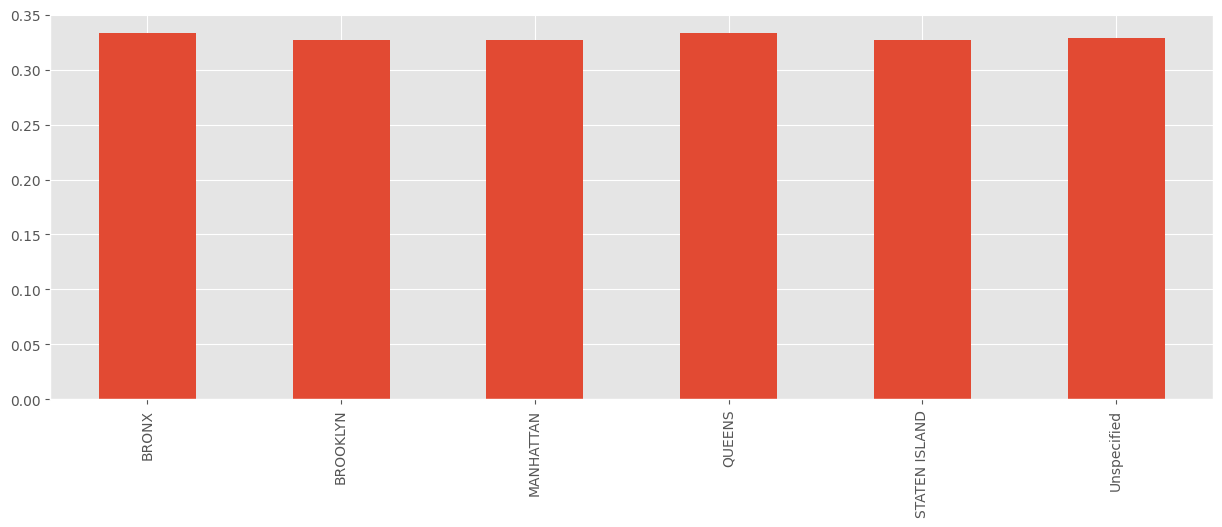

In [38]:
(noise_complaint_counts / complaint_counts.astype(float)).plot(kind='bar')

So Bronx really does complain more about noise than the other boroughs in our mock! Neat.

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [39]:
@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)

Request code execution

In [40]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [41]:
submitted_code = guest_domain_client.code[0]

In [42]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [43]:
new_project = sy.Project(name="Pandas chapter 3",
                         description="Hi, I would like to plot the histogram of the noise complaint counts per area.")

In [44]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [45]:
guest_domain_client.submit_project(new_project)

<class 'syft.service.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

## Get messages

In [46]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [47]:
messages = domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [48]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,a087a23216154aae8ced668b0d76952d,Project Approval,MessageStatus.UNDELIVERED,2023-05-16 08:23:56,<<class 'syft.service.project.project.Project'...
1,syft.service.message.messages.Message,4e6b44355f5c489d9c47cc45a3c8e00a,Approval Request,MessageStatus.UNDELIVERED,2023-05-16 08:23:54,<<class 'syft.service.request.request.Request'...


In [49]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [50]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [51]:
func

```python
class UserCode:
  id: str = a0ee74f2fde6401bb5cb66c0b7652352
  node_uid: str = efb9ad13d52c4fc6a826ecc974857ef7
  user_verify_key: str = d95c4c88c1695444d6e543192905443de7a21e21971d01b1fdd02679986e798d
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)
"
  input_policy_type: str = <class 'syft.service.policy.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='pandas-test-domain-1', verify_key=2efc2679f745defa74f60efdd3a914869e7a1749163d3ce3f50649fba4b06a3d): {'complaints': <UID: ee9cfe5eb74e4647b4d7f3e63e818802>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.service.policy.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "def user_func_get_counts_d95c4c88c1695444d6e543192905443de7a21e21971d01b1fdd02679986e798d_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20(complaints):

    def get_counts(complaints):
        is_noise = complaints['Complaint Type'] == 'Noise - Street/Sidewalk'
        noise_complaints = complaints[is_noise]
        noise_complaint_counts = noise_complaints['Borough'].value_counts()
        complaint_counts = complaints['Borough'].value_counts()
        return noise_complaint_counts / complaint_counts.astype(float)
    result = get_counts(complaints=complaints)
    return result"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_d95c4c88c1695444d6e543192905443de7a21e21971d01b1fdd02679986e798d_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  user_unique_func_name: str = "user_func_get_counts_d95c4c88c1695444d6e543192905443de7a21e21971d01b1fdd02679986e798d"
  code_hash: str = "701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  signature: str = (complaints)
  status: str = {NodeView(node_name='pandas-test-domain-1', verify_key=2efc2679f745defa74f60efdd3a914869e7a1749163d3ce3f50649fba4b06a3d): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['complaints']
  enclave_metadata: str = None

```

In [52]:
get_counts_user_func = func.unsafe_function

In [53]:
real_data = domain_client.datasets[0].assets[0].data

In [54]:
real_result = get_counts_user_func(complaints=real_data)

In [55]:
real_result[:3]

BRONX        0.014833
BROOKLYN     0.013864
MANHATTAN    0.037755
Name: Borough, dtype: float64

In [56]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [57]:
asset = guest_client.datasets[0].assets[0]

In [58]:
guest_client.api.services.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=2efc2679f745defa74f60efdd3a914869e7a1749163d3ce3f50649fba4b06a3d): <UserCodeStatus.EXECUTE: 'execute'>}

```python
Pointer
```
<AxesSubplot: >

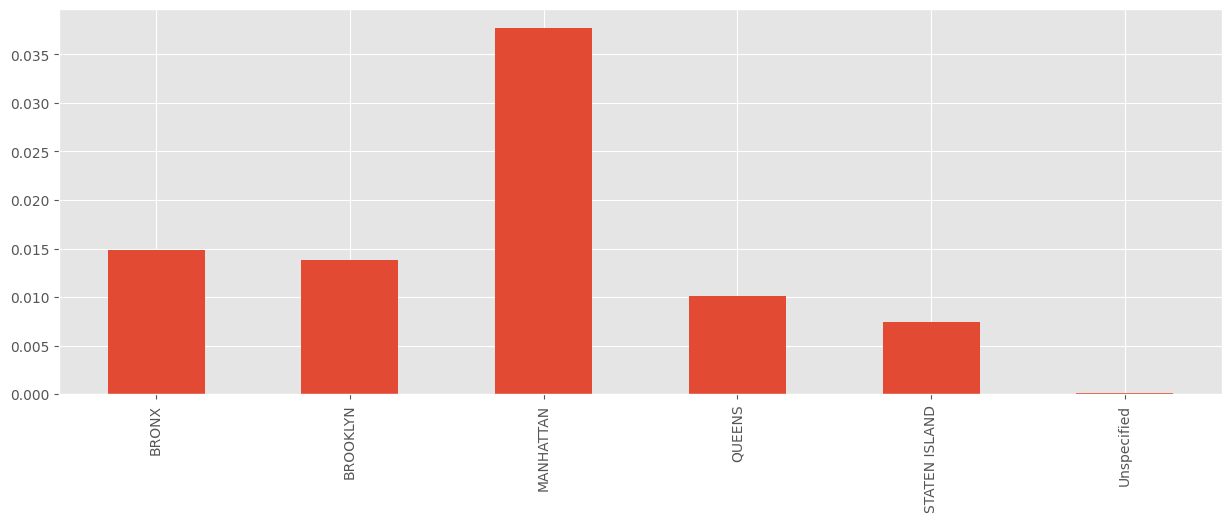

In [59]:
real_result = guest_client.api.services.code.get_counts(complaints=asset)
real_result.plot(kind="bar")